# Adversarial robustness demos

## Imports

In [1]:
import foolbox as fb
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import robustbench as rb
import art
import gc

from autoattack import AutoAttack
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

2023-05-09 09:54:18.552044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 09:54:18.619475: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Sanity checks

In [2]:
!nvidia-smi

Tue May  9 09:54:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P5    18W / 170W |    499MiB / 12288MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.list_physical_devices()

2023-05-09 09:54:20.495700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 09:54:20.497552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 09:54:20.497641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
torch.cuda.is_available()

True

In [5]:
PATH = '.'
MODEL_DIR = f'{PATH}/models'
DATA_DIR = f'{PATH}/data'
CKPT_PATH = f'{PATH}/checkpoint'
DEVICE = 'cuda:0'

## The CIFAR-10 data set

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set was originally derived in 2009 from the [80 Million Tiny Images](https://groups.csail.mit.edu/vision/TinyImages/) data set. Despite being over 20 years old, it remains one of the most heavily-used data sets for benchmarking novel machine learning algorithms (especially robustness). It consists of 70,000 RGB images 32x32 pixels in size, divided into ten classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. Samples from CIFAR-10 can be obtained easily via RobustBench:

In [6]:
x_data, y_data = rb.data.load_cifar10(n_examples=10, data_dir=DATA_DIR)

Files already downloaded and verified


In [7]:
def to_name(label):
    names = [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'
    ]
    return names[label]

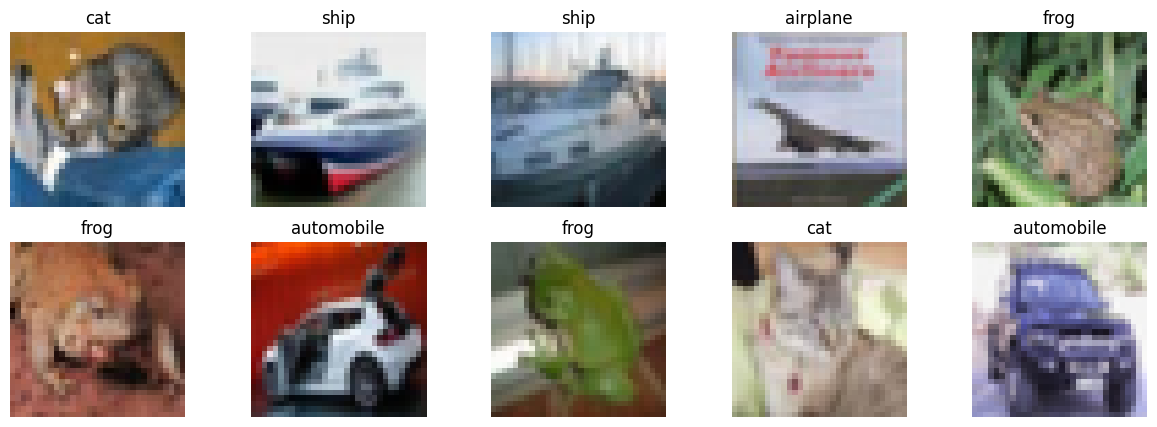

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        k = 5*i + j
        axes[i, j].set_title(to_name(y_data[k]))
        axes[i, j].imshow(np.transpose(x_data[k], [1, 2, 0]))
        axes[i, j].axis('off')
plt.show()

The full CIFAR-10 data set is also available via [torchvision](https://pytorch.org/vision/0.9/datasets.html#cifar) or the [TensorFlow data sets catalog](https://www.tensorflow.org/datasets). An extension known as CIFAR-100 is sometimes also used for benchmarking robustness.

## The fast gradient sign method

As a first demonstration of how incredibly sensitive state of the art deep learning models can be, let us load a SOTA model from the [RobustBench model zoo](https://github.com/RobustBench/robustbench#model-zoo-quick-tour):

In [9]:
standard_model = rb.load_model(model_name='Standard', dataset='cifar10', model_dir=MODEL_DIR).to(DEVICE)

The model in question is a WideResNet architecture trained via standard gradient descent methods that performs very well on CIFAR-10:

In [10]:
x_test, y_test = rb.data.load_cifar10(n_examples=128, data_dir=DATA_DIR)

Files already downloaded and verified


In [11]:
acc = rb.utils.clean_accuracy(standard_model, x_test, y_test, device=DEVICE)

In [12]:
print(f'Standard accuracy: {acc:.2%}')

Standard accuracy: 94.53%


The FGS method approximates the model loss using a first-order Taylor expansion:
$$
    L(f, x + \delta, y) \approx L(f, x, y) + \langle \delta, \nabla_x L(f, x, y) \rangle.
$$
Hence, to maximize the loss of $f$ at $x + \delta$, we need only maximize the inner product between the perturbation vector $\delta$ and the gradient vector of the loss, $\nabla_x L(f, x, y)$, provided $\delta$ remains small. This is easy to do by setting
$$
    \delta = \varepsilon \cdot \mathrm{sgn}(\nabla_x L(f, x, y))
$$
for some small $\varepsilon > 0$. In that case,
$$\begin{aligned}
    L(f, x + \delta, y)
    &\approx L(f, x, y) + \langle \delta, \nabla_x L(f, x, y) \rangle\\
    &= L(f, x, y) + \varepsilon\|\nabla_x L(f, x, y)\|_1.
\end{aligned}$$
Note that $\|\nabla_x L(f, x, y)\|_1$ is roughly proportional to the dimensionality of the input:
$$
    \|\nabla_x L(f, x, y)\|_1 = \sum_{i=1}^n\left|\frac{\partial}{\partial x_i}L(f, x, y)\right| = \mathcal{O}(n).
$$
Therefore, even if $\varepsilon$ (and hence $\delta$) is small, the increase in loss can be very large if the data is high dimensional (which it often is).

Let's put this reasoning to the test:

In [13]:
samples = x_test.clone().detach().requires_grad_().to(DEVICE)
labels = y_test.to(DEVICE)

samples.retain_grad()

loss = F.nll_loss(standard_model(samples), labels)
loss.backward()

x_grad = torch.sign(samples.grad)

epsilons = np.linspace(0, .03, 100)
accs = []
with torch.no_grad():
    for eps in tqdm(epsilons):
        delta = eps * x_grad
        x_tilde = torch.clip(samples + delta, 0, 1)

        acc = rb.utils.clean_accuracy(standard_model, x_tilde, labels)
        accs.append(acc)
        
        del x_tilde

del samples
del labels
del x_grad
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

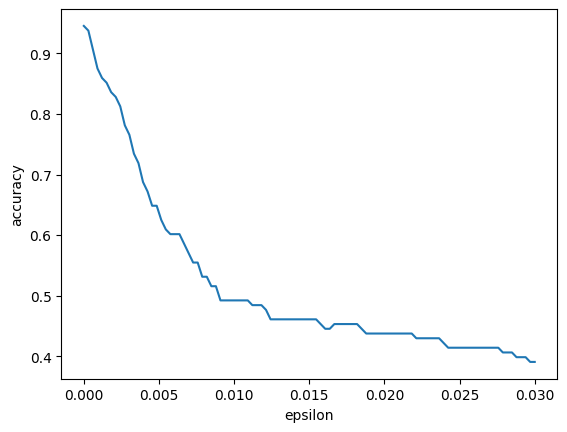

In [14]:
plt.plot(epsilons, accs)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.show()

We see here that the accuracy of this model declines rapidly with increasing values of $\varepsilon$: at $\varepsilon \approx 0.03$, the model accuracy has already dropped from over 94% to less than 40%!

It is interesting to visualize these perturbations, to get a sense of just how insignificant they are:

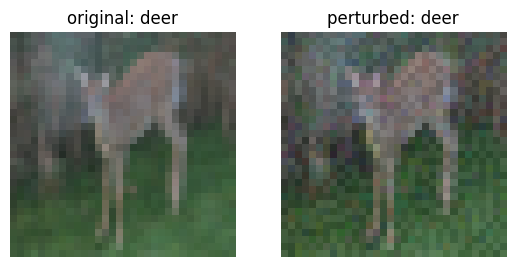

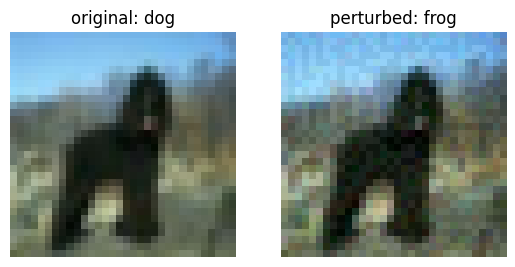

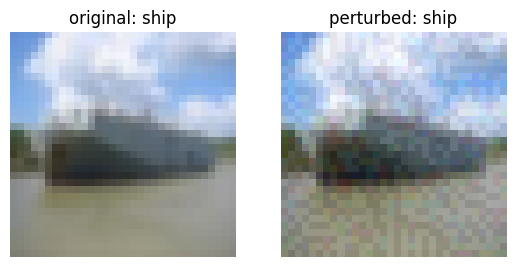

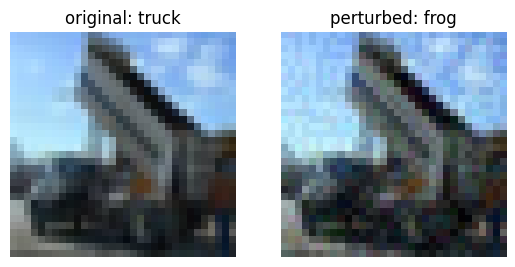

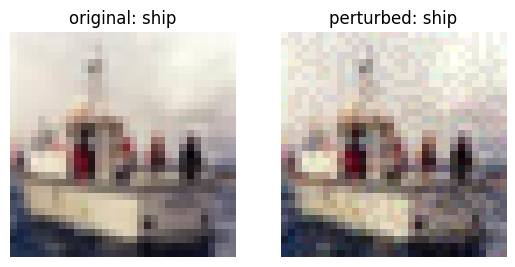

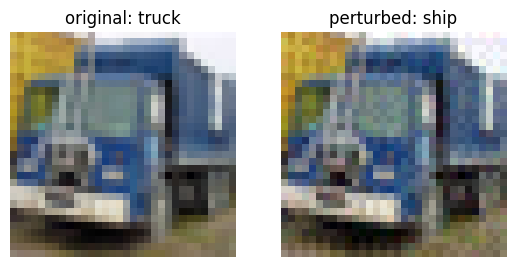

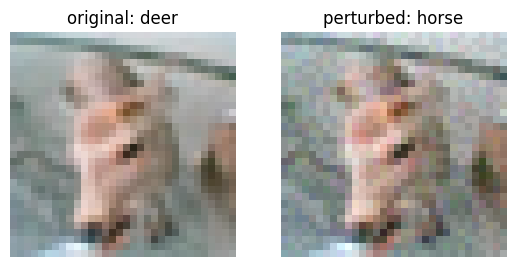

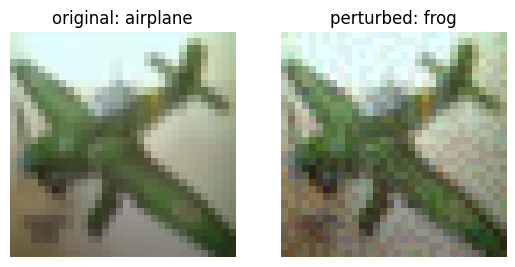

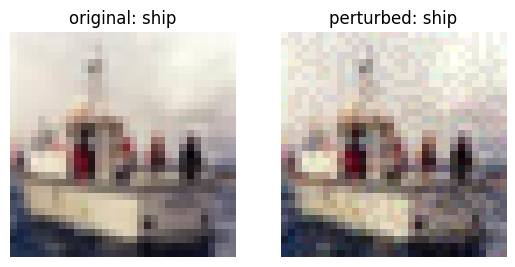

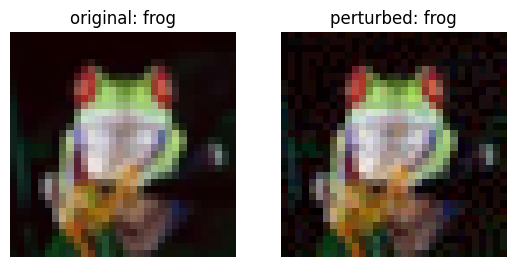

In [15]:
epsilon = .03

samples = x_test.clone().detach().requires_grad_().to(DEVICE)
labels = y_test.to(DEVICE)

samples.retain_grad()

loss = F.nll_loss(standard_model(samples), labels)
loss.backward()

with torch.no_grad():
    x_tilde = torch.clip(samples + epsilon * torch.sign(samples.grad), 0, 1)
    y_tilde = standard_model(x_tilde).cpu().detach().numpy()

    x_tilde = x_tilde.cpu().detach().numpy()
    
    y_pred = standard_model(samples).cpu().detach().numpy()

num_examples = 10
for i in range(num_examples):
    idx = np.random.randint(0, x_test.shape[0])
    
    fig, axes = plt.subplots(1, 2)
    
    axes[0].axis('off')
    axes[0].set_title(f'original: {to_name(y_pred[idx].argmax())}')
    axes[0].imshow(np.transpose(x_test[idx], [1, 2, 0]))
    
    axes[1].axis('off')
    axes[1].set_title(f'perturbed: {to_name(y_tilde[idx].argmax())}')
    axes[1].imshow(np.clip(np.transpose(x_tilde[idx], [1, 2, 0]), 0, 1))
    
    plt.show()

del samples
del labels
gc.collect()
torch.cuda.empty_cache()

The perturbations are visible in the image, of course, but they have essentially no effect on what is depicted. The fact that state of the art, highly accurate models could be so vulnerable to such seemingly insignificant perturbations came as a major shock to the machine learning community back in 2013 when this phenomenon was first described ([Szegedy et al. (2013)](https://arxiv.org/pdf/1312.6199.pdf)). The algorithm we implemented here is known as the **fast gradient sign method** (FGSM). Proposed by [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf) in 2014, it was the first *efficient* algorithm for generating adversarial examples.

## The adversarial robustness toolbox

Of course, by now there exist many open source libraries that implement a variety of attacks and defenses for us, so we don't have to program all of this by hand. Here's an example where I use the well-known [Adversarial Robustness Toolbox (ART)](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/) by IBM to generate adversarial examples against the vanilla model using the basic iterative method (BIM):

In [16]:
from art.attacks.evasion import BasicIterativeMethod
from art.estimators.classification import PyTorchClassifier

attack = BasicIterativeMethod(
    PyTorchClassifier(
        model=standard_model,
        clip_values=(0, 1),
        loss=torch.nn.CrossEntropyLoss(),
        input_shape=[3, 32, 32],
        nb_classes=10),
    eps=.03,
    eps_step=.001
)

In [17]:
x_advs = attack.generate(x=x_test.numpy())

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
acc = rb.utils.clean_accuracy(standard_model, torch.from_numpy(x_advs), y_test, device=DEVICE)

In [19]:
print(f'Accuracy: {acc:.2%}')

Accuracy: 4.69%


Where our own implementation of FGSM managed to lower the model accuracy to just under 40% at $\varepsilon = .03$, the BIM reduces it to less than 10% (the level of random guessing on the CIFAR-10 data set). This is to be expected: BIM is a simple iterative version of FGS, where we essentially just perform several iterations of FGS, projecting the result back onto the appropriate $L_\infty$ ball each time. In pseudo-code, we can describe it as

    x[0] = x_orig
    for t = 1 to T:
        x[t] = FGSM(x[t-1])
    return x[T]

## The AutoAttack benchmark

The [AutoAttack](https://github.com/fra31/auto-attack) benchmark was introduced by [Croce & Hein](https://arxiv.org/abs/2003.01690) at ICML 2020. It is intended to be a thorough and general framework for robustness evaluation. It essentially just subjects given models to a collection of different attacks and reports the worst-case performance across all of them:

* APGD-CE, a step size-free version of PGD on the cross-entropy
* APGD-DLR, a step size-free version of PGD on the DLR loss proposed by Croce & Hein,
* Fast Adaptive Boundary (FAB), which minimizes the norm of the adversarial perturbations ([Croce & Hein, 2019](https://arxiv.org/abs/1907.02044)),
* Square Attack, a query-efficient black-box attack ([Andriushchenko et al, 2019](https://arxiv.org/abs/1912.00049)).

There are several versions of the benchmark: `standard`, `plus` and `rand`. The `plus` version is more elaborate than `standard`, and the `rand` version applies the Expectation over Transformation (EoT) technique from [Athalye et al. (2018)](https://arxiv.org/abs/1802.00420). This is recommended when the defense is randomized or might be suffering from gradient masking (more on this later).

Running the benchmark is easy:

In [20]:
adversary = AutoAttack(standard_model, norm='Linf', eps=.03, version='standard')

images = x_test.to(DEVICE)
labels = y_test.to(DEVICE)

x_adv = adversary.run_standard_evaluation(images, labels, bs=128)

del images
del labels
gc.collect()
torch.cuda.empty_cache()

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 94.53%
apgd-ce - 1/1 - 121 out of 121 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 35.6 s)
max Linf perturbation: 0.03000, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%


In general, the AutoAttack benchmark can take a very long time to complete. However, the standard model we consider here is so fragile it only needs a single iteration of APGD-CE to reach 0% robust accuracy. The other attacks are not even necessary!

---

## Adversarial training

A straightforward idea for defense is **data augmentation**: simply expand the data set to include adversarial examples, so the model will learn to be robust to them the same way it learns everything else. An important design decision to implement this strategy is the specific choice of adversarial attack(s) on which to train. In particular, if the attack is *white-box* (as the strongest attacks often are), the generated adversarials will depend on the model parameters. Even if the attack is not white-box and does not need access to the model parameters, it might still be randomized and hence give different results for different runs on the same data.

These properties of adversarial attacks force us to adopt a slightly more complicated scheme, as follows:

    for every iteration of training:
        sample a mini-batch B of training data;
        generate adversarial examples for B using the current model parameters;
        train the model on a mixture of clean and adversarial samples;

This algorithm is known as **adversarial training**. Essentially, rather than augmenting the data with adversarial examples for a *fixed* model, we allow the adversarials to adapt to the model as it is trained. The resulting models exhibit much greater robustness to a broader variety of attacks than models that are trained on a static data set. Mathematically, this procedure is an approximation to solving the optimization problem
$$
    \min_\theta\mathbb{E}\left[\max_\delta L(X + \delta, Y, \theta)\right].
$$
This formulation was first articulated by [Madry et al. (2017)](https://arxiv.org/pdf/1706.06083.pdf), who introduced adversarial training with the projected gradient descent (PGD) attack. Back in 2017, this was the best known defense. At the time of this writing, PGD-based adversarial training is still considered a strong defense and in fact forms the foundation of many contemporary defenses.

In [21]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    x_train = x_train.astype(np.float32) / 255
    x_test = x_test.astype(np.float32) / 255
    
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
    
    return (x_train, y_train), (x_test, y_test), (x_val, y_val)

In [22]:
(x_train, y_train), (x_test, y_test), (x_val, y_val) = load_data()

170498071/170498071 [==============================] - 7s 0us/step


In [23]:
def create_model():
    input_layer = tf.keras.layers.Input(shape=(32, 32, 3))
    output = tf.keras.applications.ResNet50(
        include_top=False,
        weights=None,
        input_tensor=None,
        input_shape=[32, 32, 3],
        pooling='avg',
        classes=10
    )(input_layer)
    output = tf.keras.layers.LayerNormalization()(output)
    output = tf.keras.layers.Dense(10)(output)
    
    model = tf.keras.Model(input_layer, output)
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        optimizer=tf.keras.optimizers.Adam()
    )
    return model

In [24]:
def fb_attack(model, attack, x_data, y_data, epsilon=.03, batch_size=128):
    fmodel = fb.models.TensorFlowModel(model, bounds=(0, 1))

    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data.argmax(axis=1))).batch(batch_size)
    successes = []
    x_tilde = np.zeros_like(x_data)
    for b, (x_batch, y_batch) in enumerate(tqdm(dataset)):
        _, clipped_advs, _ = attack(fmodel, x_batch, y_batch, epsilons=epsilon)
        x_tilde[b*batch_size:b*batch_size + clipped_advs.shape[0], ...] = clipped_advs
    
    return x_tilde

In [25]:
robust_model = create_model()
robust_model.save_weights(CKPT_PATH)
best_loss = np.inf

epsilon = .03
ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
batch_size = 128
epochs = 10
num_batches = int(np.ceil(x_train.shape[0]) / batch_size)

fmodel = fb.models.TensorFlowModel(robust_model, bounds=(0, 1))
attack = fb.attacks.LinfPGD()

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
for epoch in range(epochs):
    for x_batch, y_batch in tqdm(dataset, desc=f'Epoch {epoch+1}/{epochs}'):
        _, x_tilde, _ = attack(fmodel, x_batch, tf.math.argmax(y_batch, axis=1), epsilons=epsilon)
        
        with tf.GradientTape() as tape:
            y_pred = robust_model(x_tilde)
            loss = ce_loss(y_batch, y_pred)
        
        grads = tape.gradient(loss, robust_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, robust_model.trainable_weights))
    
    _, acc = robust_model.evaluate(x_val, y_val, batch_size=128, verbose=0)
    print(f'Validation standard accuracy: {acc}')
    x_tilde = fb_attack(robust_model, fb.attacks.LinfPGD(), x_val, y_val)
    loss, acc = robust_model.evaluate(x_tilde, y_val, batch_size=128, verbose=0)
    print(f'Validation robust accuracy  : {acc}')
    if loss < best_loss:
        best_loss = loss
        robust_model.save_weights(CKPT_PATH)

2023-05-09 09:58:26.235095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 09:58:26.235955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 09:58:26.236091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 09:58:26.236146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-05-09 09:58:28.364022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 09:58:28.364177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 09:58:28.364233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 09:58:28.364318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 09:58:28.364371: I tensorflow/compiler/xla/stream_executo

Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

2023-05-09 09:58:29.189758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-09 09:58:29.259959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-09 09:58:32.131362: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xd902f3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-09 09:58:32.131385: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-05-09 09:58:32.145767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-09 09:58:32.288027: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

Validation standard accuracy: 0.10119999945163727


2023-05-09 10:09:50.040604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:09:50.040764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:09:50.040818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:09:50.040889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:09:50.040939: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10119999945163727


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 10:21:45.742860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:21:45.743005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:21:45.743058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:21:45.743130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:21:45.743180: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 10:33:42.364464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:33:42.364629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:33:42.364685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:33:42.364757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:33:42.364807: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 10:45:19.482498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:45:19.482641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:45:19.482695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:45:19.482767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:45:19.482817: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 10:57:06.645884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:57:06.646026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:57:06.646081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:57:06.646155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:57:06.646205: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 11:09:09.679586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:09:09.679728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:09:09.679781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:09:09.679852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:09:09.679902: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 11:21:12.728528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:21:12.728686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:21:12.728741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:21:12.728812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:21:12.728862: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


Epoch 8/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 11:33:35.364386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:33:35.364539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:33:35.364599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:33:35.364674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:33:35.364724: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


Epoch 9/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 11:46:38.192970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:46:38.193118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:46:38.193172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:46:38.193246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:46:38.193296: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


Epoch 10/10:   0%|          | 0/352 [00:00<?, ?it/s]

Validation standard accuracy: 0.10300000011920929


2023-05-09 11:59:38.942341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:59:38.942490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:59:38.942544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:59:38.942617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 11:59:38.942668: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Validation robust accuracy  : 0.10300000011920929


## Fast adversarial training

Adversarial training can be highly effective when done right. However, as you probably noticed when running the above code, it can also be extremely slow. This naturally has led to several lines of research into speeding up this training procedure. Perhaps the most remarkable (and aptly-named) is "fast adversarial training" proposed by [Wong et al. (2020)](https://arxiv.org/pdf/2001.03994.pdf). The strategy is extremely efficient and peculiar because *it's literally just fast gradient sign*, the very method we dismissed as ineffective earlier!

To elaborate, Wong et al. propose a slight variation of FGSM for use in adversarial training that does not exhibit the catastrophic overfitting and label leaking commonly observed with the original version. Specifically, they make two modifications:

1. The method does not start at the original inputs, but applies some random noise to them first.
2. The step size is modified: Wong et al. recommend using $1.25\varepsilon$ as the step size instead of the usual $\varepsilon$.

With these two simple modifications, the method not only yields significant *real* increases in robustness, it also remains just as fast as the original FGSM. Let's implement this method below.

In [26]:
def fgsm_fixed(model, x_batch, y_batch, epsilon=.03):
    alpha = 1.25 * epsilon
    deltas = tf.Variable(np.random.uniform(-epsilon, epsilon, size=x_batch.shape))
    
    ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    with tf.GradientTape() as tape:
        y_pred = model(x_batch + deltas)
        loss = ce_loss(y_batch, y_pred)
    
    grad = tape.gradient(loss, deltas)
    deltas.assign_add(alpha * tf.sign(grad))
    deltas.assign(tf.clip_by_value(deltas, -epsilon, epsilon))
    
    return np.clip(x_batch + deltas.numpy(), 0, 1)

In [27]:
fast_model = create_model()
fast_model.save_weights(CKPT_PATH)

epsilon = .03
batch_size = 128
epochs = 10
num_steps = 10
num_batches = int(np.ceil(x_train.shape[0]) / batch_size)
best_loss = np.inf
for epoch in range(epochs):
    for b in trange(num_batches, desc=f'Epoch {epoch+1}/{epochs}'):
        start = b * batch_size
        end = min((b+1) * batch_size, x_train.shape[0])
        
        x_batch = x_train[start:end]
        y_batch = y_train[start:end]
        
        x_adv_batch = fgsm_fixed(fast_model, x_batch, y_batch, epsilon)
        
        fast_model.train_on_batch(x_adv_batch, y_batch)
    
    _, clean_acc = fast_model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
    
    x_advs = fb_attack(fast_model, fb.attacks.LinfPGD(steps=num_steps), x_val, y_val)
    loss, rob_acc = fast_model.evaluate(x_advs, y_val, batch_size=batch_size, verbose=0)
    if loss < best_loss:
        best_loss = loss
        fast_model.save_weights(CKPT_PATH)
    
    print(f'Clean validation accuracy : {100*clean_acc:.2f}%')
    print(f'Robust validation accuracy: {100*rob_acc:.2f}%')

Epoch 1/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:02:15.836452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:02:15.836608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:02:15.836664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:02:15.836739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:02:15.836789: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 16.92%
Robust validation accuracy: 7.70%


Epoch 2/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:03:17.571265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:03:17.571417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:03:17.571471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:03:17.571544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:03:17.571593: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 31.06%
Robust validation accuracy: 21.72%


Epoch 3/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:04:19.841617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:04:19.841764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:04:19.841818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:04:19.841891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:04:19.841943: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 39.34%
Robust validation accuracy: 31.28%


Epoch 4/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:05:22.016922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:05:22.017070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:05:22.017125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:05:22.017199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:05:22.017249: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 39.80%
Robust validation accuracy: 33.32%


Epoch 5/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:06:24.481405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:06:24.481550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:06:24.481603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:06:24.481676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:06:24.481727: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 41.96%
Robust validation accuracy: 35.36%


Epoch 6/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:07:24.877721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:07:24.877879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:07:24.877936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:07:24.878011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:07:24.878063: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 36.38%
Robust validation accuracy: 30.64%


Epoch 7/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:08:25.536431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:08:25.536683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:08:25.536796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:08:25.536878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:08:25.536932: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 42.90%
Robust validation accuracy: 36.48%


Epoch 8/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:09:28.350648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:09:28.350803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:09:28.350858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:09:28.350933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:09:28.350983: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 45.86%
Robust validation accuracy: 39.30%


Epoch 9/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:10:30.916553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:10:30.916737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:10:30.916793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:10:30.916870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:10:30.916921: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 42.52%
Robust validation accuracy: 35.46%


Epoch 10/10:   0%|          | 0/351 [00:00<?, ?it/s]

2023-05-09 12:11:31.701045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:11:31.701184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:11:31.701239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:11:31.701316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 12:11:31.701368: I tensorflow/compiler/xla/stream_executo

  0%|          | 0/40 [00:00<?, ?it/s]

Clean validation accuracy : 44.24%
Robust validation accuracy: 38.20%


## A certified defense

One major issue with adversarial training is that it only offers *empirical* robustness. In general, there is no way to know whether an adversarially trained model will be robust to *unseen* or *adaptive* attacks. Indeed, many defenses have been broken precisely because they failed to account for new attacks and only optimized robustness on existing ones. In some sense, this is inevitable: we can only verify robustness on attacks that we know.

That said, it would be useful if we had *provable* or *certified* defenses: defenses which can guarantee mathematically that no adversarial samples exist *at all* within the given threat model. This implies that no adversarial attack, no matter how strong, could possibly find any adversarial examples provided the threat model is respected. Such methods do exist, but as you can probably imagine, certification doesn't come for free: often, certified defenses require considerably more computational resources than uncertified ones, and they tend to be empirically *less* robust than adversarially trained models.

One of the most popular certified defense methods is **randomized smoothing** ([Cohen et al. (2019)](https://arxiv.org/pdf/1902.02918.pdf)). It has several attractive properties that other certified defenses tend to lack:

* It can be applied to any existing model without having to retrain it.
* It operates on a per-sample basis, giving individualized robustness certificates for different samples.
* It is easy to implement.
* It can be parallellized to some extent.
* It has only one parameter that needs to be set in order for it to work.
* The robustness certificate is easy to compute.

Its basic operation is illustrated below.

<figure>
    <img src="images/rs.png">
    <figcaption>Illustration of the basic operation of randomized smoothing. Figure due to Cohen et al.</figcaption>
</figure>

Mathematically, randomized smoothing converts a given classifier $f$ into a "smoothed model" $g$ using the formula
$$
    g(x) = \underset{y}{\mathrm{argmax}} \Pr[f(x + \delta) = y]
$$
where $\delta \sim \mathcal{N}(0, \sigma^2I)$. Essentially, we compute $g(x)$ by corrupting the input $x$ with random perturbations $\delta$ sampled from an isotropic zero-mean Gaussian distribution $\mathcal{N}(0, \sigma^2I)$. The variance $\sigma^2$ is the only parameter required for randomized smoothing to work. Larger values yield more robust classifiers with larger certified radii around the individual samples, but this naturally comes at a greater cost to accuracy. The certified robustness radius for a given sample is then determined by the simple formula
$$
    \rho(x) = \frac{\sigma}{2}\left( \Phi^{-1}(p_A) - \Phi^{-1}(p_B) \right)
$$
where $\Phi^{-1}$ is the inverse standard Gaussian CDF. Remark that:

* The certified radius is *linear* in the standard deviation $\sigma$.
* The radius increases with the margin between the top-2 predicted class probabilities $p_A$ and $p_B$.

In [28]:
from art.estimators.certification.randomized_smoothing import PyTorchRandomizedSmoothing
rs_model = PyTorchRandomizedSmoothing(standard_model,
                                      loss=torch.nn.NLLLoss(),
                                      input_shape=(3, 32, 32),
                                      nb_classes=10,
                                      clip_values=(0, 1),
                                      scale=.01)

In [29]:
x_test, y_test = rb.data.load_cifar10(n_examples=128)
y_pred = rs_model.predict(x_test, batch_size=128)

Files already downloaded and verified


Randomized smoothing:   0%|          | 0/128 [00:00<?, ?it/s]

In [30]:
acc = (y_pred.argmax(axis=1) == y_test.numpy()).mean()
print(f'Accuracy: {acc:.2%}')

Accuracy: 92.19%


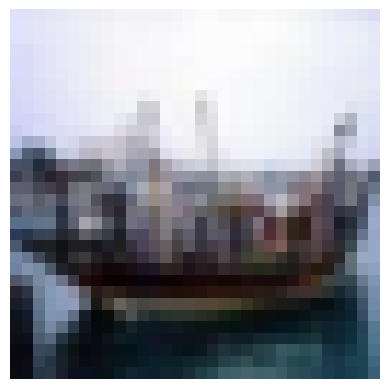

True class     : ship
Predicted class: ship
Radius         : 0.015004750241206365


In [39]:
idx = np.random.randint(0, x_test.shape[0])
p, r = rs_model.certify(x_test[:idx+1], n=100)
y = y_test[idx]

plt.imshow(np.transpose(x_test[idx], [1, 2, 0]))
plt.axis('off')
plt.show()

print(f'True class     : {to_name(y)}')
print(f'Predicted class: {to_name(p[-1])}')
print(f'Radius         : {r[-1]}')

---

## Gradient masking

Especially in the early days of adversarial robustness research, many defenses were proposed that essentially boiled down to applying JPEG compression or similar pre-processing techniques to improve robustness. The core idea was that adversarial perturbations were likely very fragile themselves, and so small corruptions in the input such as random noise or compression artifacts could probably neutralize them without affecting performance too much.

Let's take a moment to explore the effectiveness of JPEG compression as an adversarial defense. This mechanism is built into the ART library:

In [40]:
from art.defences.preprocessor import JpegCompression
compression = JpegCompression(clip_values=(0, 1))

In [41]:
x_test, y_test = rb.data.load_cifar10(n_examples=128, data_dir=DATA_DIR)
x_jpeg, _ = compression(x_test)

Files already downloaded and verified


In [42]:
attack = BasicIterativeMethod(
    PyTorchClassifier(
        model=standard_model,
        clip_values=(0, 1),
        loss=torch.nn.CrossEntropyLoss(),
        input_shape=[3, 32, 32],
        nb_classes=10),
    eps=.03,
    eps_step=.001
)

In [43]:
x_advs = attack.generate(x=x_test.numpy())

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
x_advs_jpeg, _ = compression(x_advs)

In [45]:
acc = rb.utils.clean_accuracy(standard_model, x_test, y_test, device=DEVICE)
print(f'Clean accuracy: {acc:.2%}')

Clean accuracy: 94.53%


In [46]:
acc = rb.utils.clean_accuracy(standard_model, torch.from_numpy(x_jpeg), y_test, device=DEVICE)
print(f'Clean JPEG accuracy: {acc:.2%}')

Clean JPEG accuracy: 92.97%


In [47]:
acc = rb.utils.clean_accuracy(standard_model, torch.from_numpy(x_advs), y_test, device=DEVICE)
print(f'Adversarial accuracy: {acc:.2%}')

Adversarial accuracy: 4.69%


In [48]:
acc = rb.utils.clean_accuracy(standard_model, torch.from_numpy(x_advs_jpeg), y_test, device=DEVICE)
print(f'Adversarial JPEG accuracy: {acc:.2%}')

Adversarial JPEG accuracy: 7.81%


Adding JPEG compression to adversarially perturbed samples does not seem to help much at all. However, for some reason, many papers (including most notably [Guo et al. (2018)](https://openreview.net/forum?id=SyJ7ClWCb)) proposed it as an effective defense... What's going on here?

To understand the issue here, we need to delve into the precise attack methodology used by prior work to assess robustness. Specifically, most works (including Guo et al. (2018)) applied a "model-agnostic" attack which did not take into account the details of the original model. Essentially, what they did was this:

1. Take an existing accurate model $f$.
2. Add JPEG compression (or some other transformation) as a pre-processing step to $f$, obtaining a defended model $h$.
3. Attack $h$ directly with existing attacks such as FGSM or BIM.

By contrast, we generated adversarial examples for $f$ (the original, undefended model) and fed those to the defended model $h$. This is known as a **transfer attack**, where the adversarial examples are not generated for the victim directly but rather for a different "surrogate" model. These attacks are useful when you don't know the precise details of the model you're attacking, but in particular transfer attacks are also really good at beating JPEG compression and other pre-processing based defenses.

This method of using transfer attacks to bypass defenses like JPEG compression was famously introduced by [Athalye et al. (2018)](http://proceedings.mlr.press/v80/athalye18a/athalye18a.pdf). They attributed the failure of direct attacks to a phenomenon called **gradient masking**. As the name implies, gradient masking occurs when a model (intentionally or not) distorts its own gradient information. This can happen when the model incorporates non-differentiable or numerically unstable operations, such as JPEG compression. Such operations thwart adversarial attacks that crucially rely on this information, such as fast gradient sign and the basic iterative method. We can visualize this phenomenon using the loss surface of the model. A model that does not mask gradients will have a loss surface that looks like this:

<figure>
    <img src="images/loss1.png" width="400px">
    <figcaption>Typical loss surface of a standard classifier. Different colors correspond to different predicted classes, and the height of the terrain corresponds to the classifier's confidence in the correct label. Image due to <a href="https://nicholas.carlini.com/slides/2021_sspr_stillnotrobust.pdf">Nicholas Carlini</a>.</figcaption>
</figure>

The surface is very smooth, and simply following the direction of the gradient will eventually allow you to reach a different class, thus possibly resulting in an adversarial example. When a model is masking gradients, however, we get this picture:

<figure>
    <img src="images/loss2.png" width="400px">
    <figcaption>Loss surface of a gradient masking classifier. Image due to <a href="https://nicholas.carlini.com/slides/2021_sspr_stillnotrobust.pdf">Nicholas Carlini</a>.</figcaption>
</figure>

The loss surface is essentially unchanged, but it has become much more irregular, with many additional valleys and peaks that complicate the landscape. If you simply follow the direction of the gradient to find an adversarial, you will likely get stuck in a local optimum with no obvious way to progress. This situation can be easily remedied, however, via all sorts of simple tricks:

* Approximating the gradient using numerical techniques such as finite differences instead of automatic differentiation.
* Randomly sampling around the input to smooth out the loss surface.
* Using more sophisticated optimization methods that incorporate momentum.
* Replacing non-differentiable components of the model by differentiable approximations.

Famously, by applying these simple tricks, Athalye et al. completely broke 6 out of 9 defenses submitted to ICLR 2018 before the conference even took place!

It is important to appreciate the tempting and highly intuitive, yet ultimately fallacious, reasoning that underpinned the early "successful" defenses against adversarial examples. Goodfellow et al. based their FGSM defense on the **linearity hypothesis**, the idea that adversarial examples are caused by excessive linearity of the models in the vicinity of natural data points. Hence, the accepted wisdom at the time was that we merely needed to penalize linear behavior in order to get rid of adversarials. Most of the published defenses between 2014 and 2018 focussed on this idea and simply proposed different ways to efficiently penalize linear behavior. JPEG compression is one example of this: because the compression step is not differentiable, gradient-based attacks applied to the defended model will fail since there's no useful gradient information left after compression. As we have seen, however, this doesn't actually make the model robust: it can still be easily fooled if we just ignore the compression layer.

In a sense, the adversarial machine learning community was "overfitting" on the FGSM and similar attacks that fundamentally operated on simple transformations of the loss gradient. More sophisticated attacks, such as those proposed by [Carlini & Wagner (2016)](https://arxiv.org/pdf/1608.04644.pdf) or Athalye et al., could easily evade such defenses.

Thanks to the efforts of Athalye et al., the adversarial ML community learned an important lesson:

>Always evaluate against *adaptive* adversaries.

When testing the effectiveness of a defense, it is not enough to show that the defense works against *known, existing* attacks; one must also take into account new attacks that are specifically designed to circumvent the defense you're using. This can require considerable creativity, but it is absolutely necessary to ensure that the defense has any merit.

---

## No free lunch

A natural question to ask is whether robustness to *adversarial* perturbations (which are, in some sense, "worst-case") also provides robustness to *common* perturbations such as random noise, blurring, fog and other physical distortions. To evaluate the robustness of classifiers to such common corruptions, the CIFAR-10-C ("corrupted") was proposed by [Hendrycks & Dietterich (2019)](https://openreview.net/forum?id=HJz6tiCqYm). As the name implies, this data set is comprised of samples from CIFAR-10 which have been subjected to all sorts of realistic corruptions models might actually face in reality.

The CIFAR-10-C data set is also included in RobustBench, so we can easily evaluate against it:

In [49]:
corruptions = ['fog']
x_test_c, y_test_c = rb.data.load_cifar10c(n_examples=128, corruptions=corruptions, severity=5)
x_test, y_test = rb.data.load_cifar10(n_examples=128)

Files already downloaded and verified


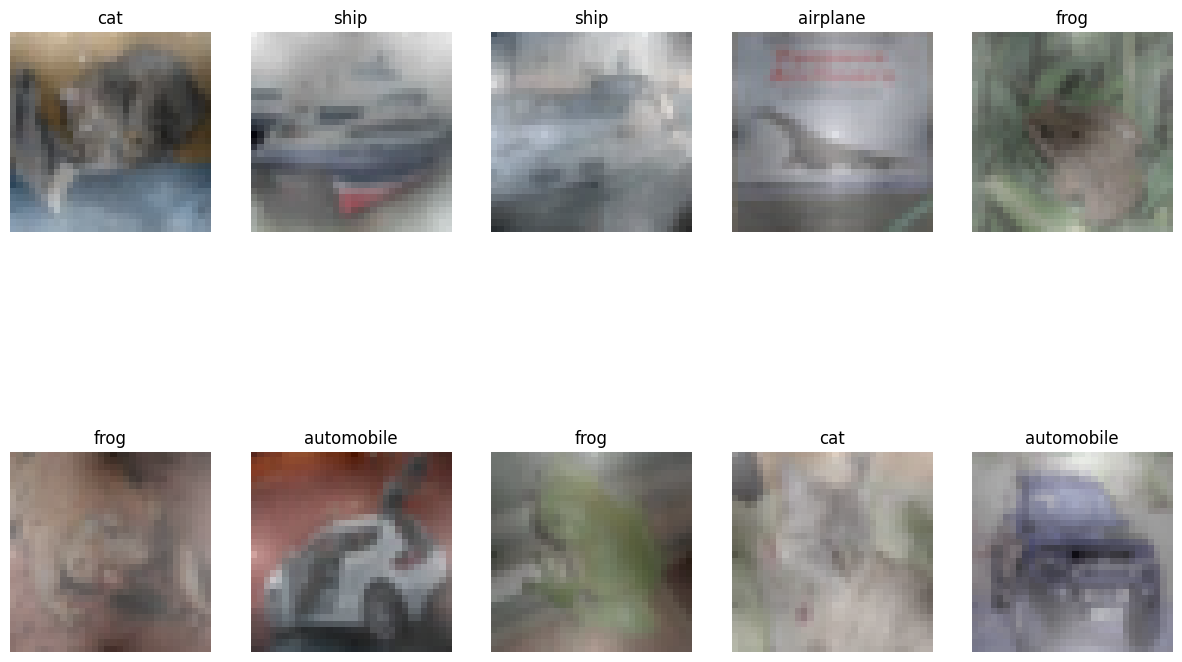

In [53]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
for i in range(2):
    for j in range(5):
        k = 5*i + j
        axes[i, j].set_title(to_name(y_test_c[k]))
        axes[i, j].imshow(np.transpose(x_test_c[k], [1, 2, 0]))
        axes[i, j].axis('off')
plt.show()

In [51]:
for model_name in ['Standard', 'Engstrom2019Robustness', 'Rice2020Overfitting', 'Carmon2019Unlabeled']:
    model = rb.load_model(model_name, dataset='cifar10', threat_model='Linf')
    c_acc = rb.utils.clean_accuracy(model, x_test_c, y_test_c)
    acc = rb.utils.clean_accuracy(model, x_test, y_test)
    print(f'Model: {model_name}')
    print(f'    CIFAR-10 accuracy  : {acc:.2%}')
    print(f'    CIFAR-10-C accuracy: {c_acc:.2%}')

Model: Standard
    CIFAR-10 accuracy  : 94.53%
    CIFAR-10-C accuracy: 81.25%
Model: Engstrom2019Robustness
    CIFAR-10 accuracy  : 90.62%
    CIFAR-10-C accuracy: 42.97%
Model: Rice2020Overfitting
    CIFAR-10 accuracy  : 86.72%
    CIFAR-10-C accuracy: 24.22%
Model: Carmon2019Unlabeled
    CIFAR-10 accuracy  : 89.06%
    CIFAR-10-C accuracy: 32.03%


---

## Practical guidelines and key take-aways

First and foremost: **always consider whether adversarial robustness is really worth it, because it might not be**. Increasing robustness generally comes at the cost of lower accuracy and higher computational overhead both during training as well as at inference time. Moreover, increasing *adversarial* robustness often also entails lowering robustness to other, more realistic corruptions such as random noise. Consider these questions:

* Is there a realistic scenario where an adversary might use adversarial examples to manipulate the system? Often (but certainly not always!), if an attacker has the level of access required to introduce adversarial examples into your system, would it not be easier for them to just install some ransomware instead?
* If there is a realistic scenario, are there other ways of dealing with this problem? In self-driving cars, for example, adversarial attacks can be thwarted by using other sources of information such as GPS and LIDAR. Mission-critical systems should in general have multiple layers of security and redundancies. Machine learning models already have significant probabilities of error in the benign setting, so even in the absence of adversaries you should not exclusively rely on a single model.
* If adversarial examples cause you to question the general reliability of the model, consider resorting to explainable AI techniques, more diverse data sets and more thorough evaluations before deployment. Maybe look at methods which improve model calibration, such as [MixUp](https://keras.io/examples/vision/mixup/) and [Dirichlet calibration](https://github.com/dirichletcal/dirichletcal.github.io).

If you *do* decide it is worth it, the following guidelines can be useful:

* **Avoid creating your own defense.** The vast majority of reasonable ideas for adversarial defense have already been tried and have been shown to fail. Getting these defenses right is extremely hard, so it is best to stick with tried-and-true methods that have been publicly verified by many researchers over many years. A similar guideline is widely accepted within the field of cryptography, where it has come to be known as [Schneier's Law](https://www.schneier.com/blog/archives/2011/04/schneiers_law.html):

> Anyone can invent a security system that they themselves cannot break. When someone hands you a security system and says, “I believe this is secure,” the first thing you have to ask is, “Who the hell are you?” Show me what you’ve broken to demonstrate that your assertion of the system’s security means something.

A reliable source for effective defenses is the [RobustBench leaderboard](https://robustbench.github.io/#leaderboard).

* Decide on a **threat model**. Typical threat models include $L_p$ norms with $p \in \{ 2, \infty \}$ and patch attacks. Patch attacks are considered to be more realistic, and specialized defenses against these attacks are often better than defenses against $L_p$ attacks ([Levine & Feizei (2020)](https://proceedings.neurips.cc/paper/2020/file/47ce0875420b2dbacfc5535f94e68433-Paper.pdf)). A reasonable estimate of the adversary's "budget" (i.e., the size of the $L_p$ perturbation, maximum dimensions of the patch, etc) is highly specific to the problem, however. Keep in mind that defending against a stronger adversary will likely mean creating a more complicated model with lower accuracy, so you will have to strike a balance.
* **Adversarial training** remains the most efficient and effective general-purpose defense method. Most new defenses incorporate adversarial training in some way, so use this as your starting point. [The adversarial robustness toolbox](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/trainer.html) provides a flexible interface for applying adversarial training to any model.
* Always use **early stopping** on the robust accuracy of a held-out validation set with adversarial training, otherwise overfitting is almost guaranteed to occur. [Rice et al. (2020)](http://proceedings.mlr.press/v119/rice20a/rice20a.pdf)
* Combine adversarial training with [model weight averaging](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/MovingAverage) and data augmentation techniques such as [CutMix](https://keras.io/examples/vision/cutmix/), [MixUp](https://keras.io/examples/vision/mixup/) and [AugMix](https://github.com/google-research/augmix). [Rebuffi et al. (2021)](https://openreview.net/pdf?id=kgVJBBThdSZ)
* Incorporating **artificial data** created by generative models also helps. [Gowal et al. (2021)](https://openreview.net/pdf?id=0NXUSlb6oEu)
* **Unlabeled data** can also be leveraged using the simple scheme of *self-training* to improve robustness. [Carmon et al. (2019)](https://github.com/yaircarmon/semisup-adv)
* Use the **[AutoAttack library](https://github.com/fra31/auto-attack)** (included with [RobustBench](https://robustbench.github.io)) to evaluate robustness. Do not forget to run AutoAttack with `version='rand'`, otherwise the result may be misleading in case of randomized defenses and gradient masking.

Common pitfalls to watch out for when performing a robustness evaluation:

* Iterative attacks should perform better than single-step attacks.
* Increasing the attack budget should strictly increase success rate. In particular, for sufficiently strong attacks (such as $L_p$ perturbations with unbounded norm), the success rate should be 100%.
* Random sampling should not perform better than adversarial attacks.

If any of the above criteria seem to be violated, this is a strong indication that the robustness you measured on your model is misleading. This could be due to e.g. gradient masking or incorrectly implemented adversarial attacks.